In [1]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import shutil

04 version
* this version we add one more summary table (algorithm = row, function = col)
* adjustbox added
* column name: best_cost changed to best_cost (mean)


In [2]:
class Experiment:
    def __init__(self, functions_file, optimization_file, opt_folder, fig_folder):
        self.functions_file = functions_file
        self.optimization_file = optimization_file
        self.functions_param=[]
        self.optimization_param=[]
        
        
        self.f_param_list_function_id=[]
        self.f_param_list_name=[]
        self.f_param_list_range_low=[]
        self.f_param_list_range_high=[]
        self.f_param_list_dimensions_vector=[]
            
        self.opt_param_list_id = []
        self.opt_param_list_name = []
        self.opt_param_list_config_file = []
            
        self.readFunctionsFile()
        self.readOptimizationFile()
        self.opt_folder = opt_folder
        self.fig_folder = fig_folder
        self.solution_file = "solutions.csv"
        self.solution_df = None
        
        #detect os windows or linux
        if os.name == 'nt':
            # Windows
            self.exec = "../bin/release/project.exe"
        else:
            # other (linux)
            self.exec = "../bin/release/project.o"
        
    def readFunctionsFile(self):
        with open(self.functions_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.functions_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.functions_param)):
            self.f_param_list_function_id.append(self.functions_param[i][0]) #function_id
            self.f_param_list_name.append(self.functions_param[i][1]) # function name
            self.f_param_list_range_low.append(self.functions_param[i][2]) # range low
            self.f_param_list_range_high.append(self.functions_param[i][3]) # range high
            self.f_param_list_dimensions_vector.append(self.functions_param[i][4:]) # dimension vector, from 4 to the last element
            
    def readOptimizationFile(self):
        with open(self.optimization_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.optimization_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.optimization_param)):
            self.opt_param_list_id.append(self.optimization_param[i][0]) #opt algorithm id
            self.opt_param_list_name.append(self.optimization_param[i][1]) #algo name
            self.opt_param_list_config_file.append(self.optimization_param[i][2]) # config file
            
    def delete_all_output_files(self):
        files = glob.glob('a*.csv')
        for f in files:
            os.remove(f)
    def moveFileToOutFolder(self, filename):
        shutil.move(filename, self.opt_folder+filename) # move file to out folder
        
    def merge_all_output_files(self):
        files = glob.glob("a*.csv")

        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['algorithm_id'
                             ,'function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv(self.opt_folder +'solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()
        plt.title('Running time')
        plt.savefig(self.fig_folder+"running_time.png",bbox_inches='tight')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1.4]})
            ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            ax1.plot(data['algorithm_id'],data['median'],label='median')
            ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            locs = [int(i) for i in self.opt_param_list_id]
            names = self.opt_param_list_name
            ax1.set_xticks(locs, minor=False)
            ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
            #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
            fig.suptitle("f%d : %s"%(id, self.f_param_list_name[id-1]), fontsize=15)
            #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
            #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax1.legend()
            ax1.set_xlabel('Algorithm')
            ax1.set_ylabel('Cost')
            ax1.grid()

            ax2.plot(data['algorithm_id'],data['time_ms'],'o-')
            ax2.set_ylabel('CPU Total Running time [ms]')
            ax2.set_xlabel('Algorithm')
            ax2.set_xticks(locs, minor=False)
            ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
            ax2.grid()
            plt.savefig(self.fig_folder + "f"+str(id)+".png",bbox_inches='tight')

        
    # run all the algorithm, 18 functions in the same time, using many CPU
    # may cause some problem with CPU clock() time... which register the cpu time of whole program
    # it seems that python is a program which call many subprocess using Popen. As a result, all the subprocess are
    # accessing to the same clock?
    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.Popen([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            # wait every process to finish
            for p in process_list:
                p.wait()
            print("----finished----alg: %s"%self.opt_param_list_name[k])
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    # run all the algorithm in sequence one function after another only only 1 CPU
    def runOneByOne(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.run([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            print("----finished----alg: %s"%self.opt_param_list_name[k])
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    def runAllLinux(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    
                    command_str =  [self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]]
                    command_str = ' '.join(command_str)
                    os.system(command_str +' &') # execute in background

            print("----running---alg: %s"%self.opt_param_list_name[k])
            print("the files should be collected manually using collectFiles()")
        

        
    def collectFiles(self):
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
        

In [3]:
test = Experiment("../config/function_list.csv", # function config file
                  "../config/optimization_alg_list_i100_p200.csv", #optimization algorithm config file
                  #"../config/optimization_alg_list_i200_p200.csv", #optimization algorithm config file
                  #"../config/optimization_alg_list_i500_p500.csv", #optimization algorithm config file
                  "../out/optimization/", # output folder for the result
                  "../out/figures/" # output folder for the figures
                 ) 

In [10]:
test.run(50) # n runs in parallel (the cpu time might not be trustful)
#test.runOneByOne(50)

----finished----alg: DE_best_1_bin
----finished----alg: DE_rand_1_bin
----finished----alg: DE_randbest_1_bin
----finished----alg: DE_best_2_bin
----finished----alg: DE_rand_2_bin
----finished----alg: GA
----finished----alg: DE_best_1_exp
----finished----alg: DE_rand_1_exp
----finished----alg: DE_randbest_1_exp
----finished----alg: DE_best_2_exp
----finished----alg: DE_rand_2_exp
----finished----alg: PSO
----finished----alg: SCA
----finished----alg: BA
----finished----alg: DBA
----finished----alg: ALO
----finished----alg: QABC


In [102]:
#test.runAllLinux(50)

In [103]:
#test.collectFiles()

In [11]:
# Tuning
#Calibration 
df=pd.read_csv('../out/optimization/solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
#tuning function 
df_f=df[df['function_id']==1]


pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.3f}'.format
#df
df_f

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,50,30,-512,512.000,1177.430,336.443,1439.600,1174.640,6472,577.033,2016.630
144,1,1,50,30,-512,512.000,2575.090,470.369,1982.490,2512.380,5493,1486.380,3468.860
162,2,1,50,30,-512,512.000,3161.440,294.324,1291.740,3111.660,8361,2373.020,3664.770
180,3,1,50,30,-512,512.000,6350.210,365.182,1788.550,6397.040,5881,5270.100,7058.650
198,4,1,50,30,-512,512.000,3607.240,683.564,3020.880,3611.220,5866,1932.470,4953.360
216,5,1,50,30,-512,512.000,1856.560,247.222,1183.480,1864.780,6958,1293.870,2477.350
234,6,1,50,30,-512,512.000,1915.330,393.097,1677.260,1843.630,5627,1026.180,2703.440
252,7,1,50,30,-512,512.000,6867.390,351.280,1455.860,6902.280,5705,5985.100,7440.960
270,8,1,50,30,-512,512.000,6763.960,513.070,2138.590,6941.090,6376,5505.640,7644.230
288,9,1,50,30,-512,512.000,2282.380,604.606,3923.350,2179.800,5970,1527.140,5450.490


pd.options.display.float_format = '{:.3f}'.format
df

plt.plot(df_f['algorithm_id'],df_f['mean'])
plt.grid()
plt.xticks(df_f['algorithm_id'])

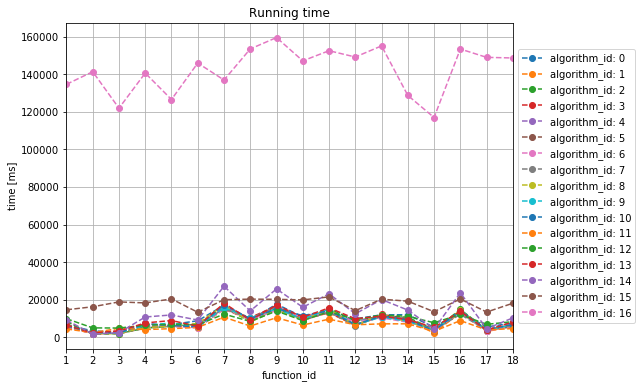

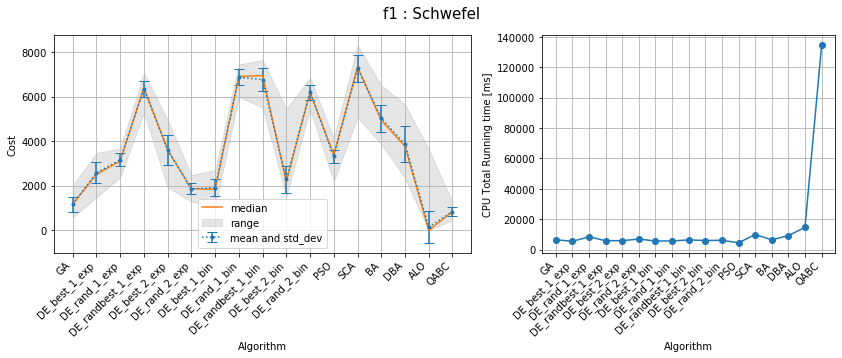

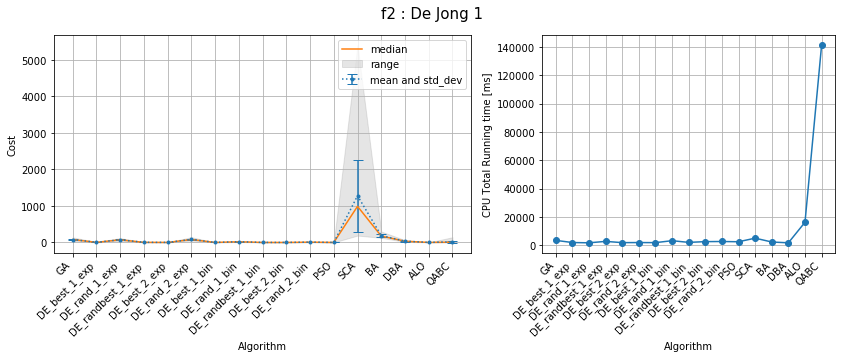

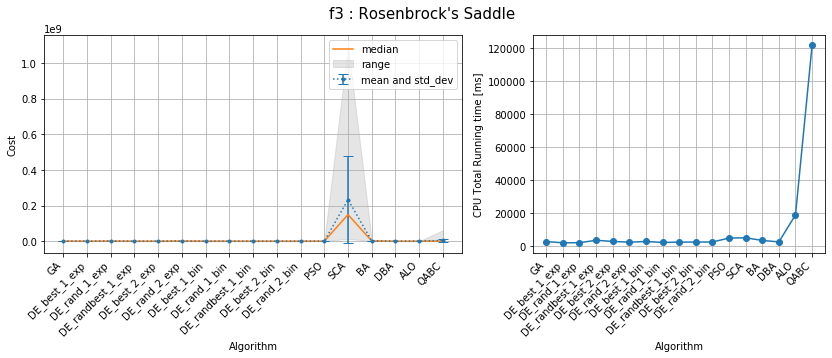

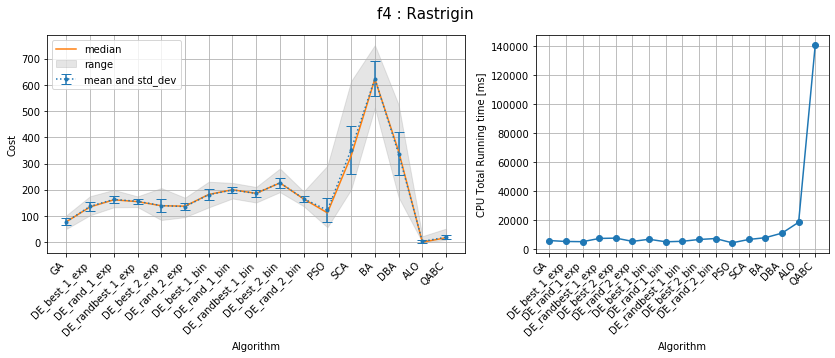

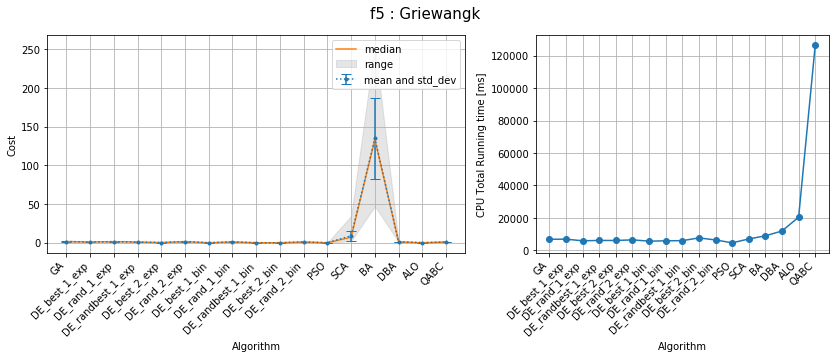

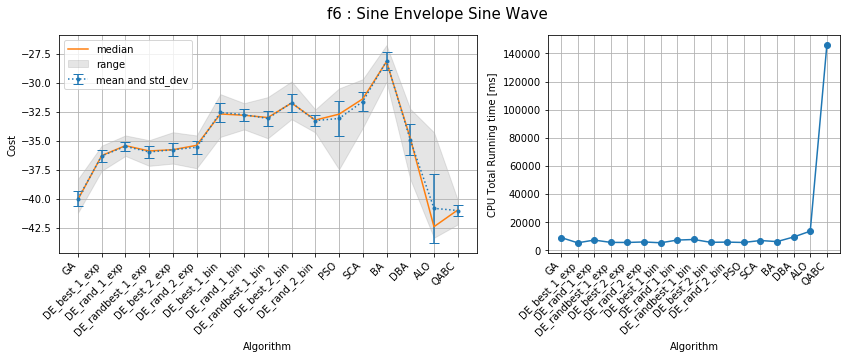

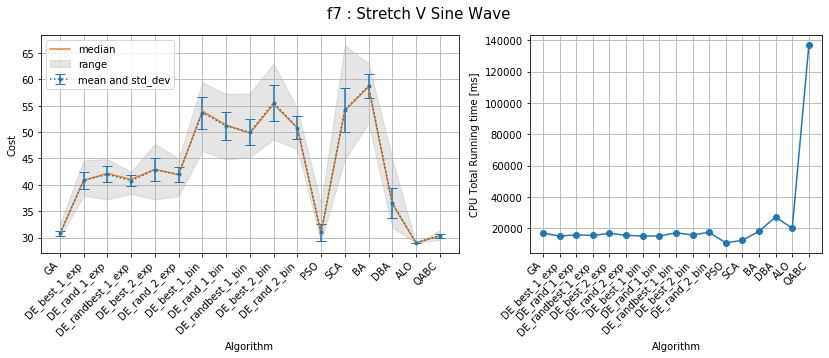

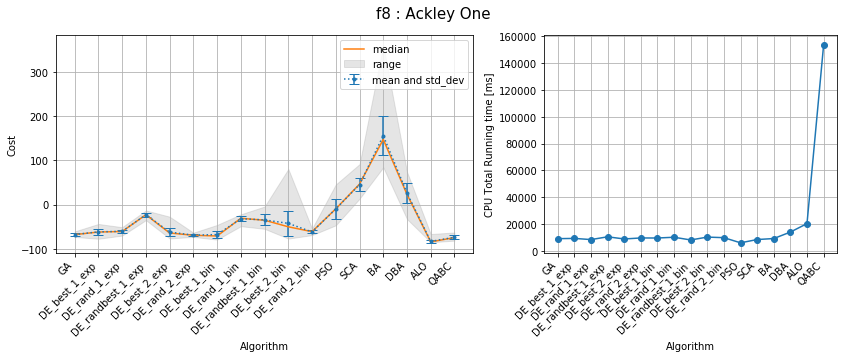

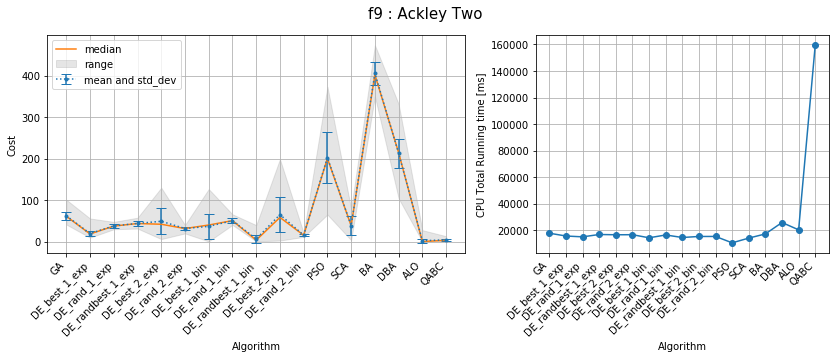

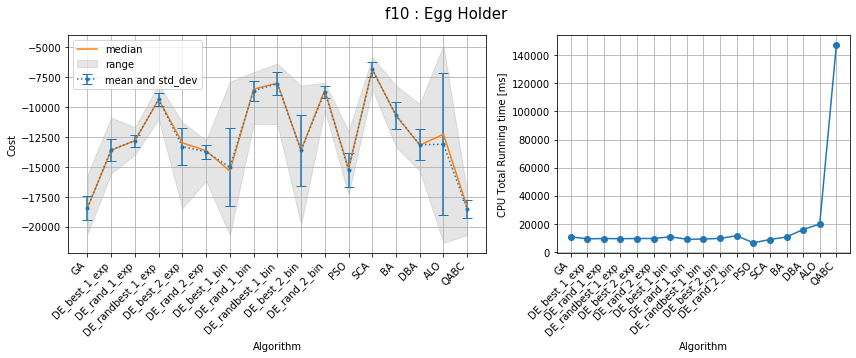

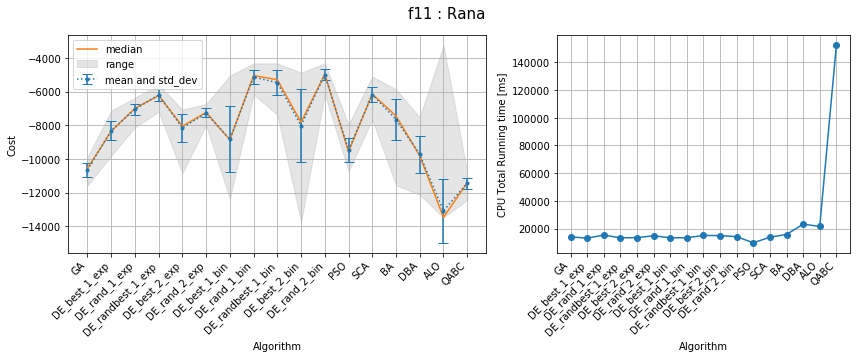

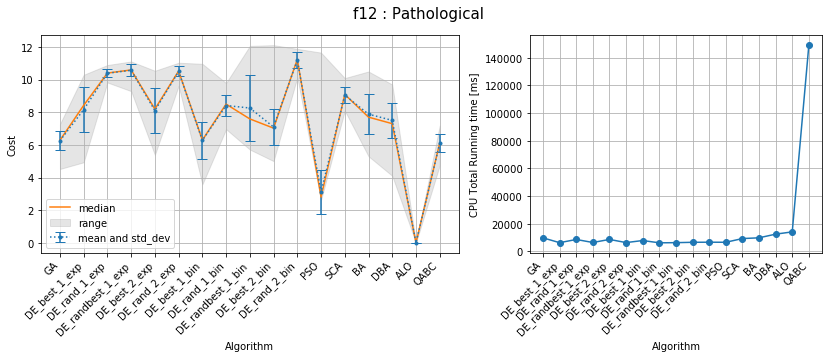

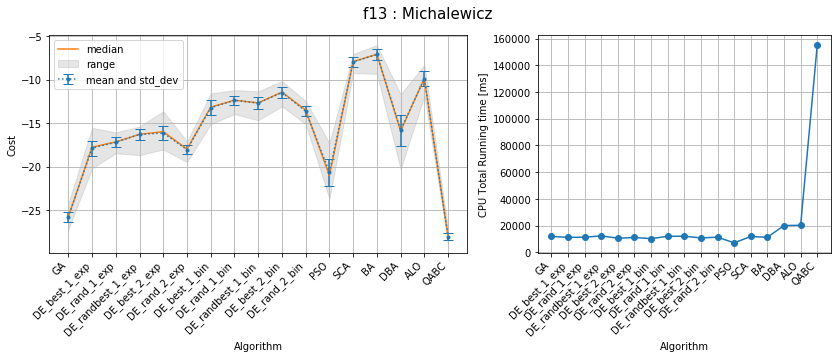

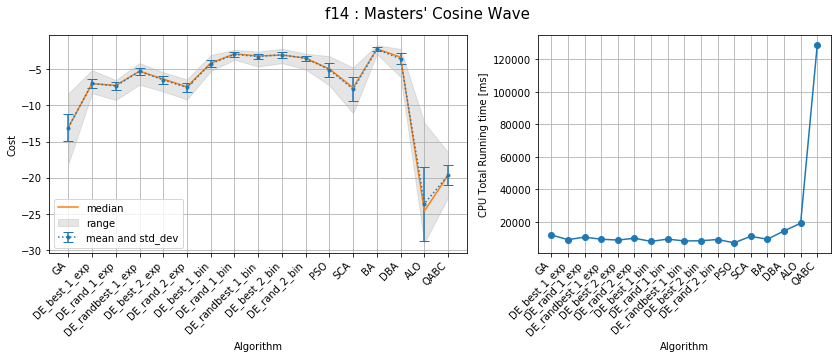

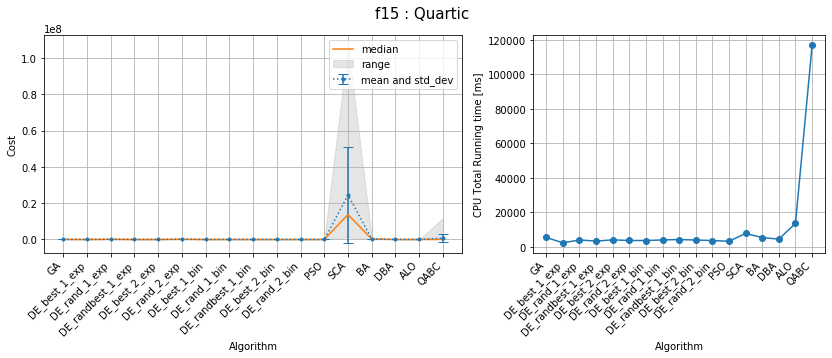

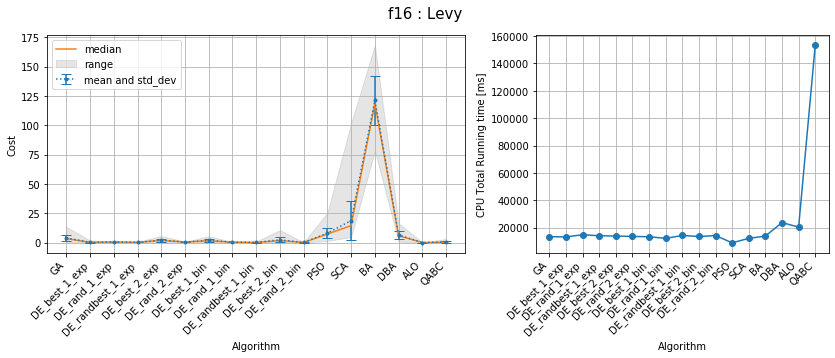

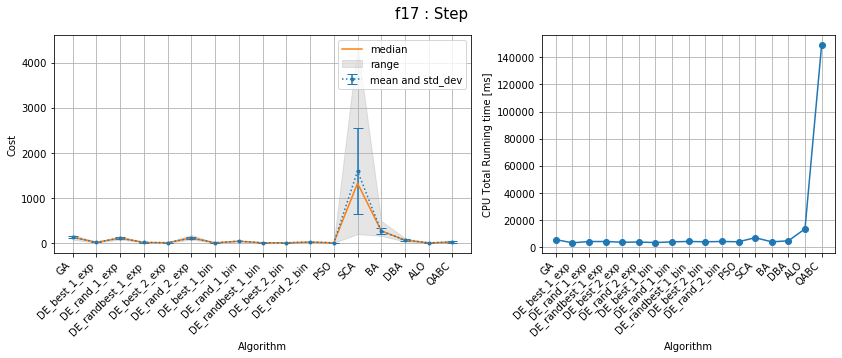

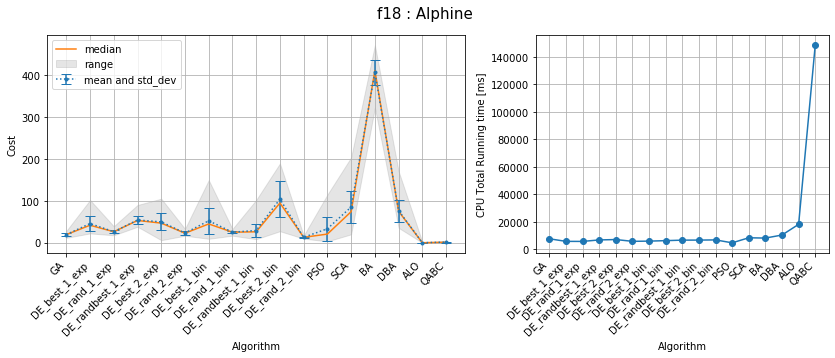

In [12]:
test.plot()

In [13]:


pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
test.solution_df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,50,30,-512,512.000,1177.430,336.443,1439.600,1174.640,6472,577.033,2016.630
10,0,2,50,30,-100,100.000,78.974,25.345,101.722,77.429,3456,36.792,138.514
11,0,3,50,30,-100,100.000,338234.000,255343.000,1043960.000,247627.000,2651,79114.900,1123070.000
12,0,4,50,30,-30,30.000,77.903,12.640,51.544,77.920,5676,50.668,102.212
13,0,5,50,30,-500,500.000,1.611,0.153,0.589,1.594,6783,1.351,1.940
14,0,6,50,30,-30,30.000,-40.002,0.631,2.906,-40.067,8813,-41.221,-38.315
15,0,7,50,30,-30,30.000,30.777,0.493,2.499,30.637,17025,30.098,32.597
16,0,8,50,30,-32,32.000,-67.417,3.237,12.531,-67.572,9100,-72.879,-60.349
17,0,9,50,30,-32,32.000,62.092,9.922,59.812,60.943,17672,41.098,100.911
1,0,10,50,30,-500,500.000,-18418.900,977.959,4958.610,-18430.300,10813,-20603.200,-15644.600


In [14]:
df = test.solution_df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,50,30,-512,512.000,1177.430,336.443,1439.600,1174.640,6472,577.033,2016.630
144,1,1,50,30,-512,512.000,2575.090,470.369,1982.490,2512.380,5493,1486.380,3468.860
162,2,1,50,30,-512,512.000,3161.440,294.324,1291.740,3111.660,8361,2373.020,3664.770
180,3,1,50,30,-512,512.000,6350.210,365.182,1788.550,6397.040,5881,5270.100,7058.650
198,4,1,50,30,-512,512.000,3607.240,683.564,3020.880,3611.220,5866,1932.470,4953.360
216,5,1,50,30,-512,512.000,1856.560,247.222,1183.480,1864.780,6958,1293.870,2477.350
234,6,1,50,30,-512,512.000,1915.330,393.097,1677.260,1843.630,5627,1026.180,2703.440
252,7,1,50,30,-512,512.000,6867.390,351.280,1455.860,6902.280,5705,5985.100,7440.960
270,8,1,50,30,-512,512.000,6763.960,513.070,2138.590,6941.090,6376,5505.640,7644.230
288,9,1,50,30,-512,512.000,2282.380,604.606,3923.350,2179.800,5970,1527.140,5450.490


# Read solution.csv, generate plot and latex report

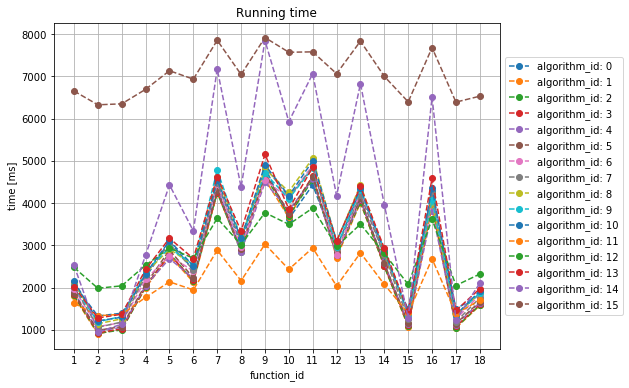

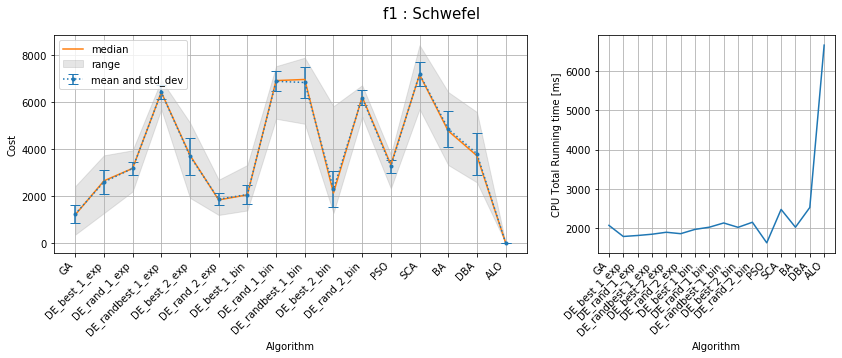

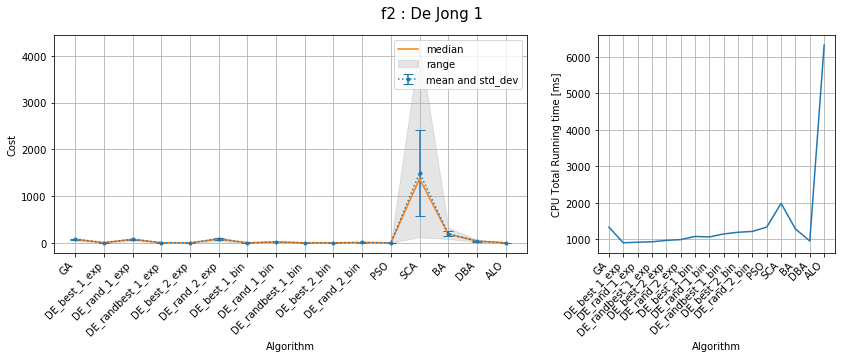

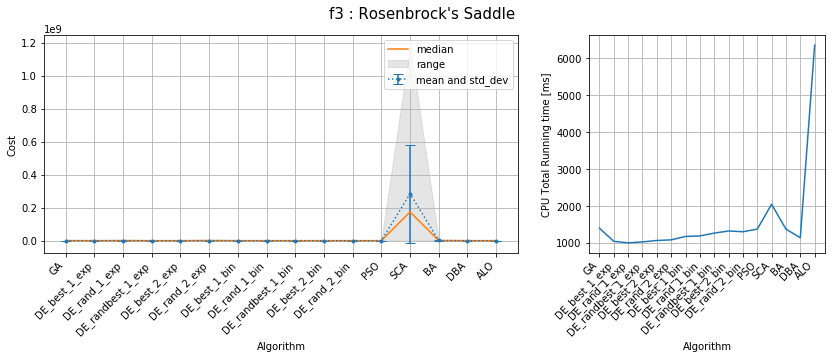

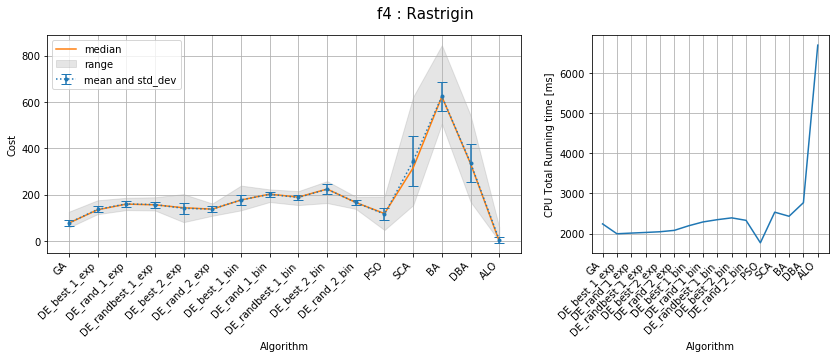

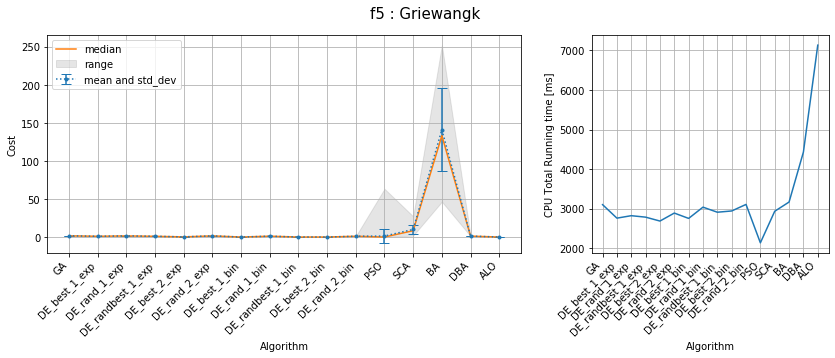

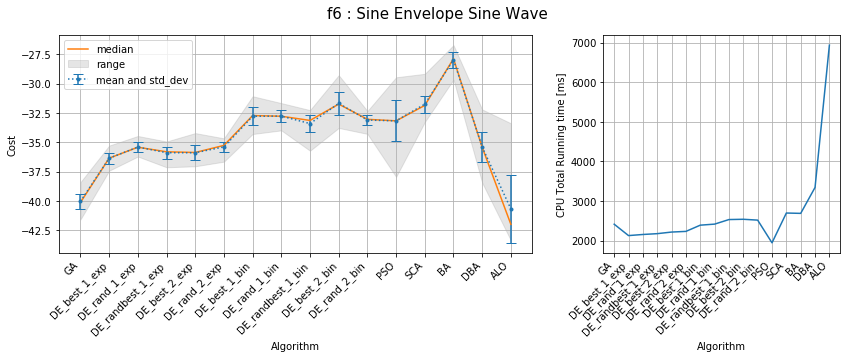

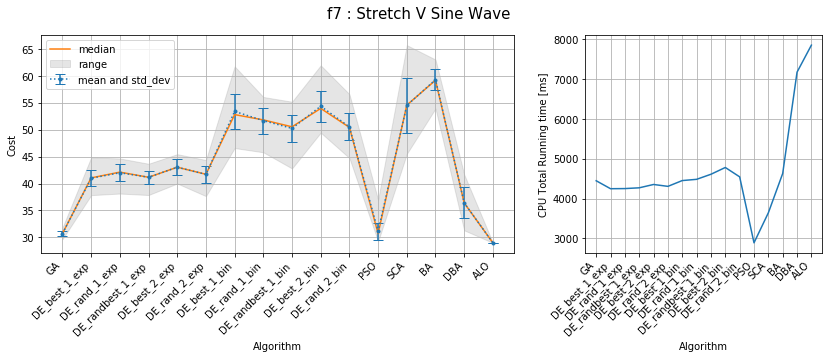

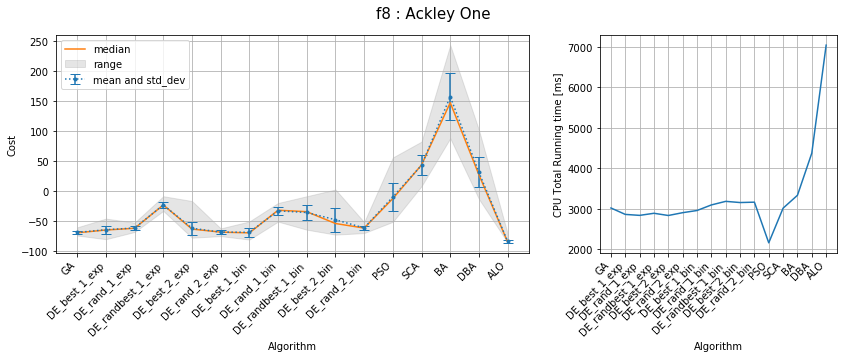

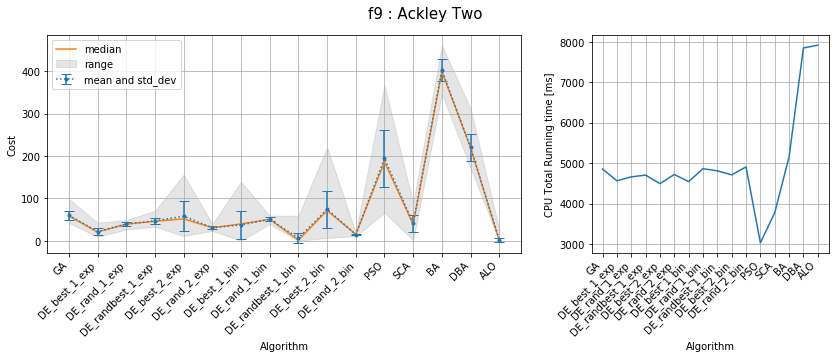

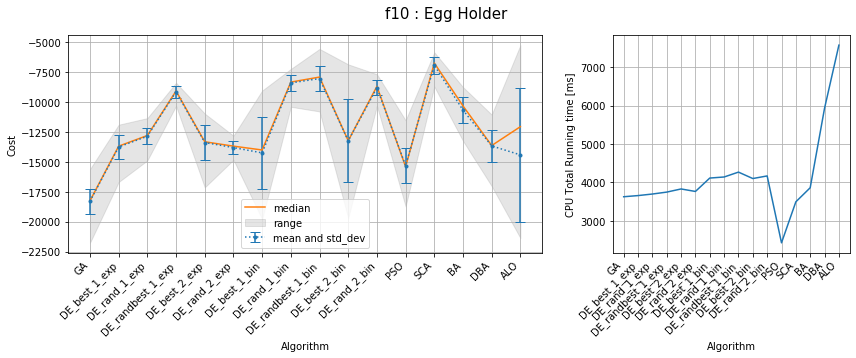

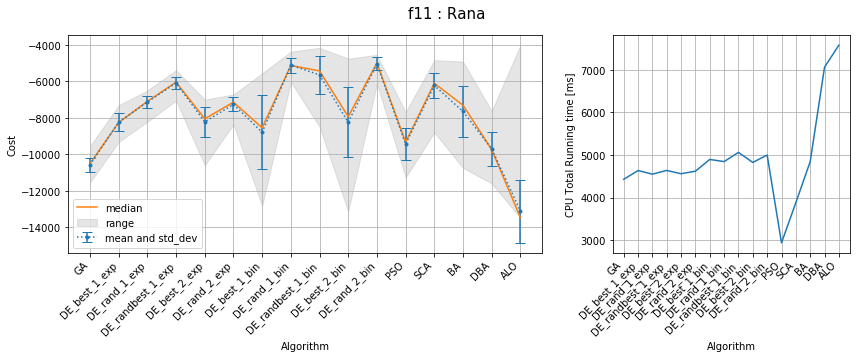

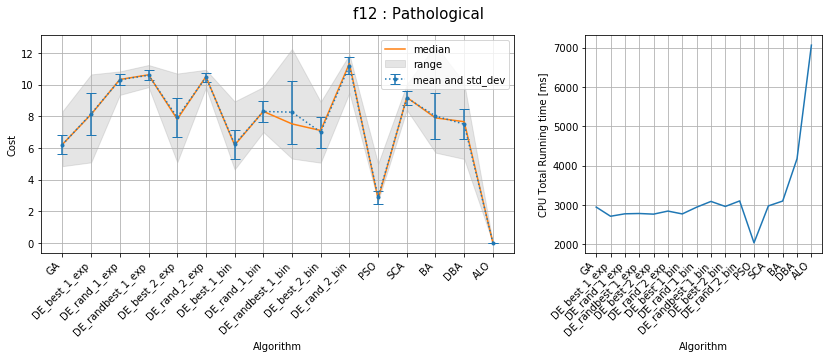

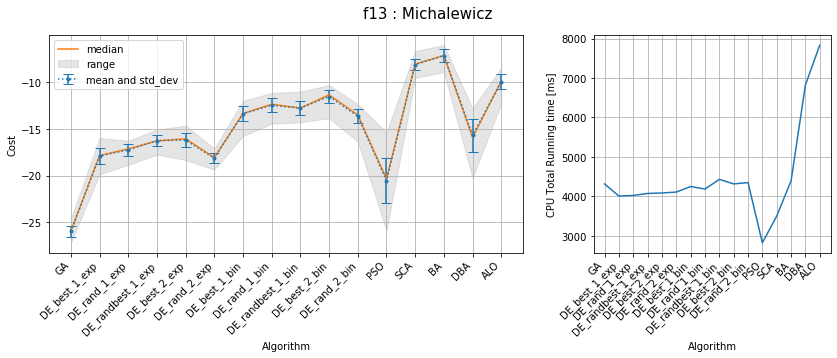

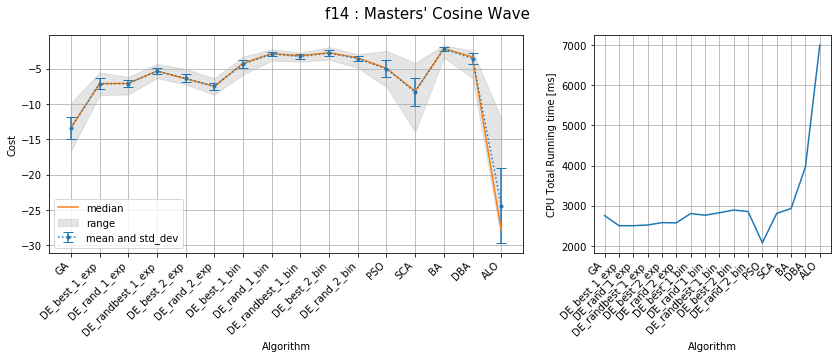

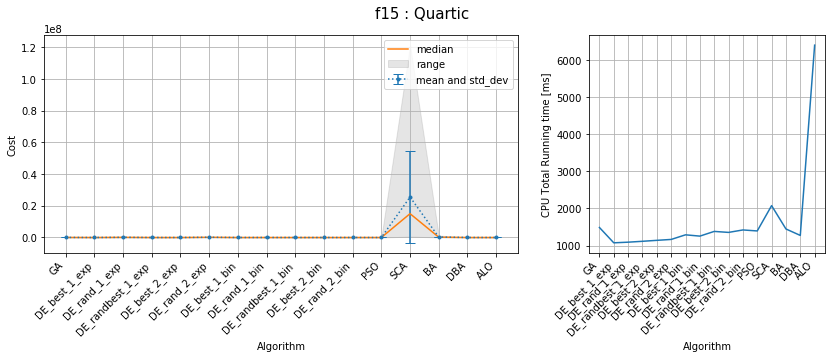

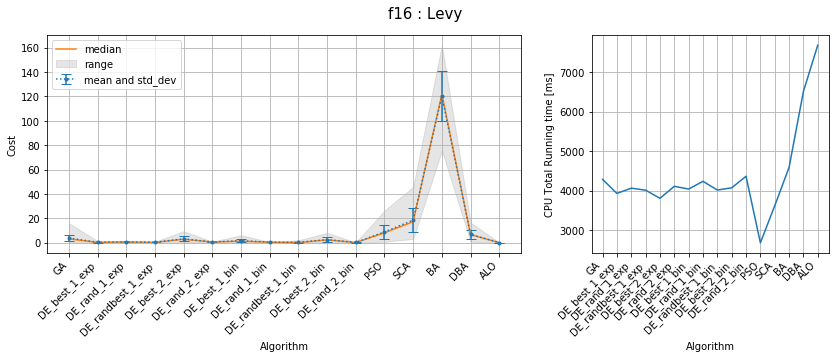

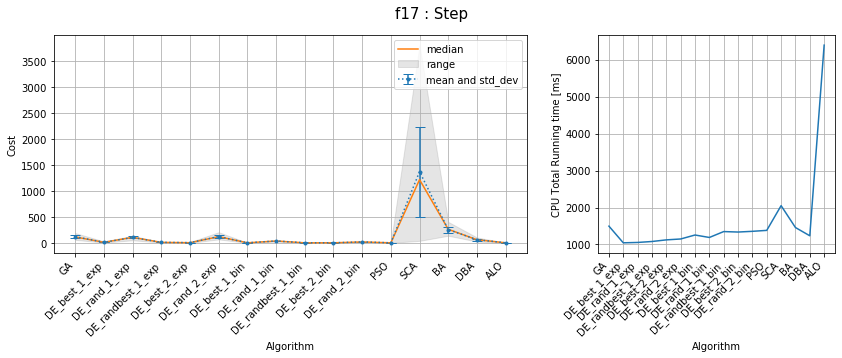

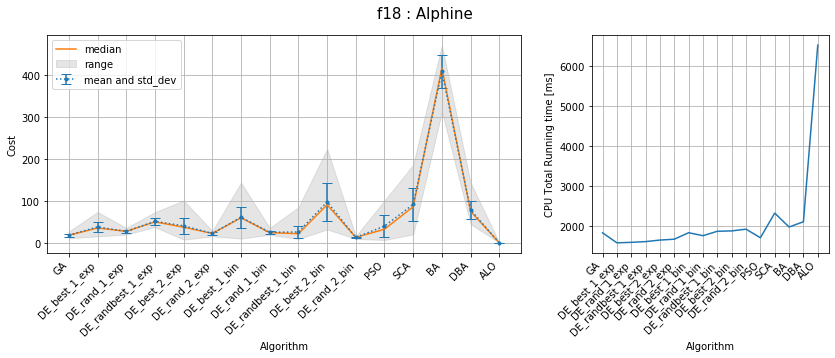

In [4]:
df=pd.read_csv("../out/03 optimization linux 100 200 ALO/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)


#-----------plot running time
fig, ax = plt.subplots(figsize=(8,6))
for label, data in df.groupby('algorithm_id'):
    data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
plt.ylabel('time [ms]')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('Running time')
#plt.savefig("running_time.png",bbox_inches='tight')


#---------plot statistics
for id, data in df.groupby('function_id'):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
    ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
    ax1.plot(data['algorithm_id'],data['median'],label='median')
    ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
    locs = [int(i) for i in test.opt_param_list_id]
    names = test.opt_param_list_name
    ax1.set_xticks(locs, minor=False)
    ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
    #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
    fig.suptitle("f%d : %s"%(id, test.f_param_list_name[id-1]), fontsize=15)
    #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.legend()
    ax1.set_xlabel('Algorithm')
    ax1.set_ylabel('Cost')
    ax1.grid()
    
    ax2.plot(data['algorithm_id'],data['time_ms'])
    ax2.set_ylabel('CPU Total Running time [ms]')
    ax2.set_xlabel('Algorithm')
    ax2.set_xticks(locs, minor=False)
    ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
    ax2.grid()
    plt.savefig("f"+str(id)+".png",bbox_inches='tight')


In [8]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
126,0,1,50,30,-512,512.000,291.715,252.889,1342.790,233.445,30556.100,0.065,1342.860
226,1,1,50,30,-512,512.000,413.589,204.703,846.204,462.697,21489.300,-0.001,846.203
183,2,1,50,30,-512,512.000,0.001,0.001,0.003,0.001,21405.800,-0.000,0.003
67,3,1,50,30,-512,512.000,3542.440,305.624,1428.860,3618.260,23376.400,2698.730,4127.590
35,4,1,50,30,-512,512.000,987.060,321.703,1386.780,925.399,22160.100,462.703,1849.480
178,5,1,50,30,-512,512.000,-0.002,0.000,0.002,-0.002,21582.000,-0.003,-0.001
130,6,1,50,30,-512,512.000,1757.670,359.702,1355.990,1728.670,22986.300,1147.530,2503.530
68,7,1,50,30,-512,512.000,5261.550,396.785,1730.240,5335.010,25214.300,4231.200,5961.440
142,8,1,50,30,-512,512.000,2124.900,1093.450,5061.780,1840.380,26134.600,1066.570,6128.350
189,9,1,50,30,-512,512.000,1824.540,364.970,1713.930,1789.090,24220.600,821.697,2535.630


## read df

In [22]:
#df=pd.read_csv("../out/03 optimization linux 100 200 ALO/"+'solutions.csv',index_col=False)
#df=pd.read_csv("../out/03 optimization linux 200 200/"+'solutions.csv',index_col=False)
df=pd.read_csv("../out/03 optimization linux 500 500/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)

## support codes for latex report generation

In [15]:
# https://stats.stackexchange.com/questions/124096/two-samples-z-test-in-python
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

z, p = twoSampZ(1330, 1350, 0, 388.5, 190.64, 50, 50)

In [16]:
df_s = df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df_s
n_sample = df_s["n_runs"].iloc[0]

# print the table and export to latex

In [17]:
def print_latex_function(function_id):
    df_fx = df_s[df_s["function_id"]==function_id] # dataframe of function_id
    
    # get name of the algorithms
    alg_id = [str(i) for i in df_fx["algorithm_id"].values.tolist()] # convert algorithm id to string
    alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
    alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
    # insert algorithms name to the dataframe
    df_fx = df_fx[["mean","std_dev","median","range_min","range_max","time_ms"]]
    df_fx.insert(0,"algorithm",alg_name)
    #display(df_fx)
    
    # get name of the functions
    f_index = test.f_param_list_function_id.index(str(function_id))
    f_name = test.f_param_list_name[f_index]
    
        
    print("\\newpage")    
    #print subsection 
    print("\\subsection{Function %d: %s}"%(function_id, f_name))
    
    
    #print function
    print("""
    \\begin{figure}[H]
    \\centering
    
    \\includegraphics[width=1\\linewidth]{{"figures/03 optimization linux 100 200 ALO/figures/f%d"}.png}
    
    \\caption{Cost and CPU total running time of Function %d: %s} 
    \\label{fig:f%d}
    \\end{figure}
    """%(function_id, function_id, f_name, function_id))


    
    # print latex table
    print("""\\begin{table}[H]
    \\centering
    \\footnotesize
    \\begin{adjustbox}{width=1\\textwidth}""")
    print(df_fx.to_latex(index=False))
    print("""
    \\end{adjustbox}
    \\caption{Function %d: Statistical Analysis of the Cost} 
    \\end{table}"""%function_id)
    
    
    # Hypothesis testing 
    #find the min beside GA
    #df_ga = df_fx[df_fx["algorithm"]=="GA"]
    #df_fx = df_fx[df_fx["algorithm"]!="GA"]
    min_index = df_fx[['mean']].idxmin()
    df_min = df_fx.loc[min_index] # minimun 
    x1=df_min["mean"].values[0]
    sd1=df_min["std_dev"].values[0]
    
   
    min_latex = df_min["algorithm"].values[0].replace("_","\_")
    print("Best Algorithm: \\\\")
    print("\\textbf{%s}, Cost (mean): %f\\\\"%(min_latex, x1))
        
    # save the good algorithms after the hypothesis testing
    good_alg = []
    # compare everyone with the best
    already_printed=False
    for index, row in df_fx.iterrows():
        if index != min_index.values[0]: #exclude compare with itself
  
            #get name
            current_latex = row["algorithm"].replace("_","\_")
            
            #preparing data for z-test (two sample)
            x2=row["mean"]
            sd2=row["std_dev"]

            z,p = twoSampZ(x1,x2,0,sd1,sd2,n_sample,n_sample)

            

            if(p>0.05):
                if not already_printed:
                    print("\\noindent")
                    print("\\textbf{Two-Sample Z-Test Hypothesis Testing: }")
                    print("confidence interval = 95\%\\\\")
                    print("\\vspace{-3mm}")
                    print("\\rule[3mm]{\\linewidth}{0.2pt}")
                    print("Null hypothesis: The best algorithm and the tested one are equal\\\\")
                    already_printed = True
          
                print("\\textbf{%s}, Cost (mean): %f"%(current_latex, x2))
                print(", P value: %f\\\\"%p)
                #print("\\textbf{the cost of %s is equal to the cost of %s}.\\\\"%(current_latex, min_latex))
                good_alg.append(row["algorithm"])
    
    return good_alg

print_latex_function(8)

\newpage
\subsection{Function 8: Ackley One}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/03 optimization linux 100 200 ALO/figures/f8"}.png}
    
    \caption{Cost and CPU total running time of Function 8: Ackley One} 
    \label{fig:f8}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
    \begin{adjustbox}{width=1\textwidth}
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &    mean &  std\_dev &  median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA & -67.417 &    3.237 & -67.572 &    -72.879 &    -60.349 &     9100 \\
     DE\_best\_1\_exp & -61.404 &    6.466 & -61.799 &    -76.942 &    -43.532 &     9300 \\
     DE\_rand\_1\_exp & -60.205 &    3.320 & -60.538 &    -69.782 &    -50.805 &     8416 \\
 DE\_randbest\_1\_exp & -22.692 &    4.501 & -22.617 &    -34.842 &    -13.023 &    10487 \\
     DE\_best\_2\_exp & -61.843 &    9.586 & -63.954 &    -76.333 &    -27.033 &     8880 \\
 

[]

## Print latex

In [18]:
function_list = df_s["function_id"].unique()
good_algs = []
for i in function_list:
    good_algs.append(print_latex_function(i))

\newpage
\subsection{Function 1: Schwefel}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/03 optimization linux 100 200 ALO/figures/f1"}.png}
    
    \caption{Cost and CPU total running time of Function 1: Schwefel} 
    \label{fig:f1}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
    \begin{adjustbox}{width=1\textwidth}
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &     mean &  std\_dev &   median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA & 1177.430 &  336.443 & 1174.640 &    577.033 &   2016.630 &     6472 \\
     DE\_best\_1\_exp & 2575.090 &  470.369 & 2512.380 &   1486.380 &   3468.860 &     5493 \\
     DE\_rand\_1\_exp & 3161.440 &  294.324 & 3111.660 &   2373.020 &   3664.770 &     8361 \\
 DE\_randbest\_1\_exp & 6350.210 &  365.182 & 6397.040 &   5270.100 &   7058.650 &     5881 \\
     DE\_best\_2\_exp & 3607.240 &  683.564 & 3611.220 &   1932.470 &   4953.360 &     5

\newpage
\subsection{Function 18: Alphine}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/03 optimization linux 100 200 ALO/figures/f18"}.png}
    
    \caption{Cost and CPU total running time of Function 18: Alphine} 
    \label{fig:f18}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
    \begin{adjustbox}{width=1\textwidth}
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &    mean &  std\_dev &  median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA &  19.444 &    3.995 &  19.402 &     11.736 &     28.098 &     7603 \\
     DE\_best\_1\_exp &  45.735 &   16.844 &  41.709 &     22.263 &    101.806 &     5729 \\
     DE\_rand\_1\_exp &  26.307 &    3.822 &  26.238 &     17.811 &     39.302 &     5690 \\
 DE\_randbest\_1\_exp &  54.171 &   10.598 &  53.053 &     38.156 &     89.903 &     6774 \\
     DE\_best\_2\_exp &  49.735 &   20.520 &  46.743 &      6.120 &    104.916 &     7043 \\
   

## get algorithms with similar result comparing to the best

In [19]:
good_algs_s = [", ".join(i) for i in good_algs]
good_algs_s

['',
 '',
 'DE_randbest_1_bin, PSO',
 '',
 'DE_best_1_bin, DE_randbest_1_bin',
 'ALO',
 '',
 '',
 '',
 'GA',
 '',
 '',
 '',
 '',
 'DE_best_2_bin, ALO',
 '',
 'PSO, ALO',
 '']

In [20]:
df_similar=pd.DataFrame(list(zip(function_list,good_algs_s)), columns = ['function_id','similar_result'])

# print summary table

In [21]:
df_summary = df.sort_values(by=['algorithm_id','function_id'], inplace = False)
df_summary

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,50,30,-512,512.000,1177.430,336.443,1439.600,1174.640,6472,577.033,2016.630
10,0,2,50,30,-100,100.000,78.974,25.345,101.722,77.429,3456,36.792,138.514
11,0,3,50,30,-100,100.000,338234.000,255343.000,1043960.000,247627.000,2651,79114.900,1123070.000
12,0,4,50,30,-30,30.000,77.903,12.640,51.544,77.920,5676,50.668,102.212
13,0,5,50,30,-500,500.000,1.611,0.153,0.589,1.594,6783,1.351,1.940
14,0,6,50,30,-30,30.000,-40.002,0.631,2.906,-40.067,8813,-41.221,-38.315
15,0,7,50,30,-30,30.000,30.777,0.493,2.499,30.637,17025,30.098,32.597
16,0,8,50,30,-32,32.000,-67.417,3.237,12.531,-67.572,9100,-72.879,-60.349
17,0,9,50,30,-32,32.000,62.092,9.922,59.812,60.943,17672,41.098,100.911
1,0,10,50,30,-500,500.000,-18418.900,977.959,4958.610,-18430.300,10813,-20603.200,-15644.600


In [22]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = alg_name[alg_id.index(str(label))]
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
display(df_result)
print(df_result.to_latex(index=False))

c:\users\chao_\miniconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSO,SCA,BA,DBA,ALO,QABC
0,1,1177.430,2575.090,3161.440,6350.210,3607.240,1856.560,1915.330,6867.390,6763.960,2282.380,6198.040,3316.760,7260.970,5032.300,3869.680,143.976,843.371
1,2,78.974,3.904,72.772,2.641,0.517,82.140,0.003,19.226,0.002,0.006,7.767,0.001,1279.480,186.497,34.395,0.010,16.122
2,3,338234.000,9718.930,627829.000,1830.630,2690.410,773060.000,197.640,68334.800,588.583,583.328,37752.400,60144.600,233206000.000,1349370.000,44443.000,4.097,4453380.000
3,4,77.903,136.816,162.908,155.888,139.609,135.850,181.146,199.177,185.803,226.498,165.820,121.561,352.991,623.680,337.323,2.744,19.453
4,5,1.611,0.989,1.456,0.958,0.296,1.513,0.016,1.120,0.019,0.021,1.048,0.015,8.997,135.004,1.221,0.087,0.923
5,6,-40.002,-36.316,-35.490,-35.974,-35.785,-35.566,-32.570,-32.765,-33.086,-31.734,-33.268,-33.090,-31.634,-28.149,-34.925,-40.830,-41.020
6,7,30.777,40.850,41.978,40.816,42.859,41.992,53.672,51.177,49.976,55.568,50.858,31.012,54.246,58.769,36.617,29.001,30.344
7,8,-67.417,-61.404,-60.205,-22.692,-61.843,-68.865,-67.551,-31.669,-34.323,-42.254,-61.550,-9.326,45.392,156.273,26.276,-82.937,-73.668
8,9,62.092,19.411,37.785,43.745,48.932,31.483,36.661,50.290,6.408,64.942,15.539,202.614,38.528,405.805,212.905,1.984,4.167
9,10,-18418.900,-13557.300,-12797.600,-9350.060,-13295.000,-13738.500,-15022.200,-8622.710,-8031.910,-13618.200,-8704.270,-15220.500,-6848.860,-10682.700,-13130.600,-13111.800,-18530.000


\begin{tabular}{rrrrrrrrrrrrrrrrrr}
\toprule
 function\_id &         GA &  DE\_best\_1\_exp &  DE\_rand\_1\_exp &  DE\_randbest\_1\_exp &  DE\_best\_2\_exp &  DE\_rand\_2\_exp &  DE\_best\_1\_bin &  DE\_rand\_1\_bin &  DE\_randbest\_1\_bin &  DE\_best\_2\_bin &  DE\_rand\_2\_bin &        PSO &           SCA &          BA &        DBA &        ALO &        QABC \\
\midrule
           1 &   1177.430 &       2575.090 &       3161.440 &           6350.210 &       3607.240 &       1856.560 &       1915.330 &       6867.390 &           6763.960 &       2282.380 &       6198.040 &   3316.760 &      7260.970 &    5032.300 &   3869.680 &    143.976 &     843.371 \\
           2 &     78.974 &          3.904 &         72.772 &              2.641 &          0.517 &         82.140 &          0.003 &         19.226 &              0.002 &          0.006 &          7.767 &      0.001 &      1279.480 &     186.497 &     34.395 &      0.010 &      16.122 \\
           3 & 338234.000 &       9718.930 & 

In [23]:
df_result

,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSO,SCA,BA,DBA,ALO,QABC
0,1,1177.430,2575.090,3161.440,6350.210,3607.240,1856.560,1915.330,6867.390,6763.960,2282.380,6198.040,3316.760,7260.970,5032.300,3869.680,143.976,843.371
1,2,78.974,3.904,72.772,2.641,0.517,82.140,0.003,19.226,0.002,0.006,7.767,0.001,1279.480,186.497,34.395,0.010,16.122
2,3,338234.000,9718.930,627829.000,1830.630,2690.410,773060.000,197.640,68334.800,588.583,583.328,37752.400,60144.600,233206000.000,1349370.000,44443.000,4.097,4453380.000
3,4,77.903,136.816,162.908,155.888,139.609,135.850,181.146,199.177,185.803,226.498,165.820,121.561,352.991,623.680,337.323,2.744,19.453
4,5,1.611,0.989,1.456,0.958,0.296,1.513,0.016,1.120,0.019,0.021,1.048,0.015,8.997,135.004,1.221,0.087,0.923
5,6,-40.002,-36.316,-35.490,-35.974,-35.785,-35.566,-32.570,-32.765,-33.086,-31.734,-33.268,-33.090,-31.634,-28.149,-34.925,-40.830,-41.020
6,7,30.777,40.850,41.978,40.816,42.859,41.992,53.672,51.177,49.976,55.568,50.858,31.012,54.246,58.769,36.617,29.001,30.344
7,8,-67.417,-61.404,-60.205,-22.692,-61.843,-68.865,-67.551,-31.669,-34.323,-42.254,-61.550,-9.326,45.392,156.273,26.276,-82.937,-73.668
8,9,62.092,19.411,37.785,43.745,48.932,31.483,36.661,50.290,6.408,64.942,15.539,202.614,38.528,405.805,212.905,1.984,4.167
9,10,-18418.900,-13557.300,-12797.600,-9350.060,-13295.000,-13738.500,-15022.200,-8622.710,-8031.910,-13618.200,-8704.270,-15220.500,-6848.860,-10682.700,-13130.600,-13111.800,-18530.000


## print summary table 2

In [24]:
def print_table2(f_id):
    df_result2 = df_summary.groupby(by=["algorithm_id"], as_index=False).first()
    df_result2 = df_result2[["algorithm_id"]] # get the dataframe of only function id

    #f_id = df_summary["function_id"].unique()
    #f_id = range(1,10)
    f_id = [str(i) for i in f_id]    # convert algorithm id to string


    f_index = [test.f_param_list_function_id.index(i) for i in f_id] # get the index of alg id
    f_name = [test.f_param_list_name[i] for i in f_index] # get the name

    for label, data in df_summary.groupby('function_id'):
        if str(label) in f_id:
            temp = data[["algorithm_id","mean"]]

            #new_name = f_name[f_id.index(str(label))]
            new_name = "f" + str(label)
            temp.rename(columns={'mean': new_name}, inplace=True)
            #display(temp)

            df_result2=df_result2.merge(temp, on=["algorithm_id"], how='left') 

    # convert algorithm id to algorithm name

    alg_names = []
    for index, row in df_result2.iterrows():
        alg_names.append(alg_name[alg_id.index(str(int(row["algorithm_id"])))])
    df_result2.insert(loc=0, column='algorithm', value=alg_names)

    df_result2 = df_result2.drop(columns = ["algorithm_id"])


    display(df_result2)
    print(df_result2.to_latex(index=False))

In [25]:
print_table2(range(1,10))

,algorithm,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,GA,1177.430,78.974,338234.000,77.903,1.611,-40.002,30.777,-67.417,62.092
1,DE_best_1_exp,2575.090,3.904,9718.930,136.816,0.989,-36.316,40.850,-61.404,19.411
2,DE_rand_1_exp,3161.440,72.772,627829.000,162.908,1.456,-35.490,41.978,-60.205,37.785
3,DE_randbest_1_exp,6350.210,2.641,1830.630,155.888,0.958,-35.974,40.816,-22.692,43.745
4,DE_best_2_exp,3607.240,0.517,2690.410,139.609,0.296,-35.785,42.859,-61.843,48.932
5,DE_rand_2_exp,1856.560,82.140,773060.000,135.850,1.513,-35.566,41.992,-68.865,31.483
6,DE_best_1_bin,1915.330,0.003,197.640,181.146,0.016,-32.570,53.672,-67.551,36.661
7,DE_rand_1_bin,6867.390,19.226,68334.800,199.177,1.120,-32.765,51.177,-31.669,50.290
8,DE_randbest_1_bin,6763.960,0.002,588.583,185.803,0.019,-33.086,49.976,-34.323,6.408
9,DE_best_2_bin,2282.380,0.006,583.328,226.498,0.021,-31.734,55.568,-42.254,64.942


\begin{tabular}{lrrrrrrrrr}
\toprule
         algorithm &       f1 &       f2 &            f3 &      f4 &      f5 &      f6 &     f7 &      f8 &      f9 \\
\midrule
                GA & 1177.430 &   78.974 &    338234.000 &  77.903 &   1.611 & -40.002 & 30.777 & -67.417 &  62.092 \\
     DE\_best\_1\_exp & 2575.090 &    3.904 &      9718.930 & 136.816 &   0.989 & -36.316 & 40.850 & -61.404 &  19.411 \\
     DE\_rand\_1\_exp & 3161.440 &   72.772 &    627829.000 & 162.908 &   1.456 & -35.490 & 41.978 & -60.205 &  37.785 \\
 DE\_randbest\_1\_exp & 6350.210 &    2.641 &      1830.630 & 155.888 &   0.958 & -35.974 & 40.816 & -22.692 &  43.745 \\
     DE\_best\_2\_exp & 3607.240 &    0.517 &      2690.410 & 139.609 &   0.296 & -35.785 & 42.859 & -61.843 &  48.932 \\
     DE\_rand\_2\_exp & 1856.560 &   82.140 &    773060.000 & 135.850 &   1.513 & -35.566 & 41.992 & -68.865 &  31.483 \\
     DE\_best\_1\_bin & 1915.330 &    0.003 &       197.640 & 181.146 &   0.016 & -32.570 & 53.672 & -67.5

In [26]:
print_table2(range(10,19))

,algorithm,f10,f11,f12,f13,f14,f15,f16,f17,f18
0,GA,-18418.900,-10633.800,6.259,-25.810,-13.075,46984.900,3.960,130.398,19.444
1,DE_best_1_exp,-13557.300,-8311.270,8.163,-17.869,-6.978,1314.760,0.237,18.129,45.735
2,DE_rand_1_exp,-12797.600,-7039.710,10.394,-17.198,-7.323,94210.600,0.545,113.329,26.307
3,DE_randbest_1_exp,-9350.060,-6192.800,10.577,-16.295,-5.310,42.515,0.267,16.601,54.171
4,DE_best_2_exp,-13295.000,-8152.820,8.102,-16.132,-6.480,482.483,1.960,10.418,49.735
5,DE_rand_2_exp,-13738.500,-7262.460,10.504,-18.048,-7.531,108786.000,0.479,116.481,23.120
6,DE_best_1_bin,-15022.200,-8829.830,6.280,-13.217,-4.237,0.058,1.808,7.726,52.308
7,DE_rand_1_bin,-8622.710,-5121.090,8.415,-12.370,-2.962,9672.290,0.378,43.973,25.169
8,DE_randbest_1_bin,-8031.910,-5465.440,8.263,-12.677,-3.257,1.162,0.169,7.664,29.170
9,DE_best_2_bin,-13618.200,-8011.050,7.099,-11.469,-3.016,0.154,2.354,7.849,103.995


\begin{tabular}{lrrrrrrrrr}
\toprule
         algorithm &        f10 &        f11 &    f12 &     f13 &     f14 &          f15 &     f16 &      f17 &     f18 \\
\midrule
                GA & -18418.900 & -10633.800 &  6.259 & -25.810 & -13.075 &    46984.900 &   3.960 &  130.398 &  19.444 \\
     DE\_best\_1\_exp & -13557.300 &  -8311.270 &  8.163 & -17.869 &  -6.978 &     1314.760 &   0.237 &   18.129 &  45.735 \\
     DE\_rand\_1\_exp & -12797.600 &  -7039.710 & 10.394 & -17.198 &  -7.323 &    94210.600 &   0.545 &  113.329 &  26.307 \\
 DE\_randbest\_1\_exp &  -9350.060 &  -6192.800 & 10.577 & -16.295 &  -5.310 &       42.515 &   0.267 &   16.601 &  54.171 \\
     DE\_best\_2\_exp & -13295.000 &  -8152.820 &  8.102 & -16.132 &  -6.480 &      482.483 &   1.960 &   10.418 &  49.735 \\
     DE\_rand\_2\_exp & -13738.500 &  -7262.460 & 10.504 & -18.048 &  -7.531 &   108786.000 &   0.479 &  116.481 &  23.120 \\
     DE\_best\_1\_bin & -15022.200 &  -8829.830 &  6.280 & -13.217 &  -4.237 &

## get best cost without time

In [27]:
df_best = df_result[["function_id"]]
df_best["best_algorithm"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost (mean)"] = df_result.drop(columns=["function_id"]).min(axis=1)
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,best_algorithm,best_cost (mean)
0,1,ALO,143.976
1,2,PSO,0.001
2,3,ALO,4.097
3,4,ALO,2.744
4,5,PSO,0.015
5,6,QABC,-41.020
6,7,ALO,29.001
7,8,ALO,-82.937
8,9,ALO,1.984
9,10,QABC,-18530.000


In [28]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
df_best_similar = df_best.merge(df_similar, on=["function_id"], how='left') 
df_best_similar

,function_id,best_algorithm,best_cost (mean),similar_result
0,1,ALO,143.976,
1,2,PSO,0.001,
2,3,ALO,4.097,"DE_randbest_1_bin, PSO"
3,4,ALO,2.744,
4,5,PSO,0.015,"DE_best_1_bin, DE_randbest_1_bin"
5,6,QABC,-41.020,ALO
6,7,ALO,29.001,
7,8,ALO,-82.937,
8,9,ALO,1.984,
9,10,QABC,-18530.000,GA


In [38]:
print(df_best_similar.to_latex(index=False))

\begin{tabular}{rlrl}
\toprule
 function\_id &     best\_algorithm &  best\_cost (mean) &                                                                                                                            similar\_result \\
\midrule
 1 &  DE\_rand\_2\_exp & -0.002 &  ALO \\
 2 &  ALO & 0.000 &  DE\_best\_2\_exp \\
 3 &  ALO & 0.098 &  PSO \\
 4 &  DE\_rand\_2\_exp & 0.000 &   \\
 5 &  DE\_rand\_2\_bin & 0.000 &  DE\_rand\_2\_exp \\
 6 &  ALO & -43.380 &   \\
 7 &  ALO & 29.000 &   \\
 8 &  DE\_rand\_1\_exp & -86.333 &  DE\_rand\_2\_exp, DE\_rand\_1\_bin, DE\_rand\_2\_bin \\
 9 &  DE\_rand\_2\_bin & 0.000 &  DE\_best\_1\_exp, DE\_randbest\_1\_exp, DE\_randbest\_1\_bin, ALO \\
 10 &  DE\_best\_1\_exp & -22301.800 &   \\
 11 &  DE\_best\_1\_exp & -13277.900 &  ALO \\
 12 &  ALO & 0.000 &   \\
 13 &  GA & -29.191 &   \\
 14 &  ALO & -29.000 &   \\
 15 &  DE\_best\_1\_bin & 0.000 &  DE\_best\_1\_exp, DE\_randbest\_1\_exp, DE\_best\_2\_exp, DE\_rand\_2\_exp, DE\_randbest\_1\_bin \\
 

## get best cost with time

In [70]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = int(label)
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
#display(df_result)
#print(df_result.to_latex(index=False))

In [71]:
df_best = df_result[["function_id"]]
df_best["algorithm_id"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
temp = df[["algorithm_id", "function_id", "time_ms"]]
df_best = df_best.merge(temp, on=["function_id","algorithm_id"], how='left') 
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,algorithm_id,best_cost,time_ms
0,1,0,1330.170,2158.370
1,2,8,0.002,1249.120
2,3,6,520.354,1260.940
3,4,0,-67715.300,2311.080
4,5,8,0.011,2978.360
5,6,0,-40.070,2505.260
6,7,0,30.665,4661.080
7,8,0,-68.615,3126.870
8,9,8,8.953,4897.940
9,10,0,-18226.300,3839.400
